# Import des librairies

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier

In [2]:
data = pd.read_csv('nutri_nettoyé.csv', delimiter=",")

C:\Users\nha5600\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Analyse du fichier

In [3]:
data.shape

(206506, 36)

In [4]:
data.head(3)

,code,url,creator,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Banana Chips Sweetened (Whole),NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),...,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14,14.0
1,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Peanuts,NaN,Torn & Glasser,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),...,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0,0.0
2,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Organic Salted Nut Mix,NaN,Grizzlies,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),...,7.1,17.86,1.22428,0.482,0.0,0.0000,0.143,0.00514,12,12.0


Nous allons commencer l'exploration des données en effectuant dans un premier temps des analyses univariées sur nos indicateurs : Les additifs, la présence d'huile de palme, la présence de conservateurs, le nutriscore et le nutrigrade.

# Analyse univariée

Pour notre analyse, nous voyons d'où viennent la plupart de nos produits, afin de proposer des recommandations adaptées aux consommateurs :

In [5]:
# on affiche le nombre de produit par pays
data_countries = data["countries_fr"].value_counts()

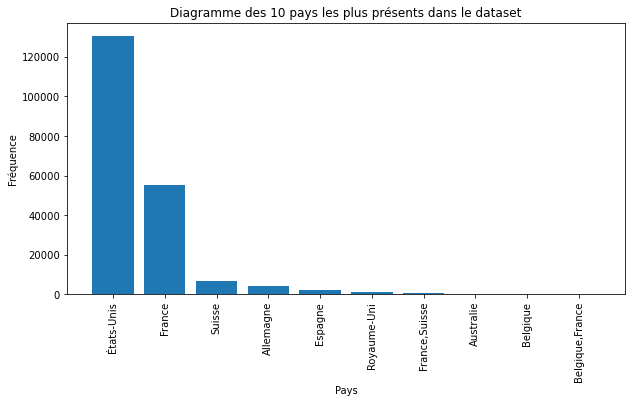

In [6]:
# Création graphique des pays les plus représenté
plt.figure(figsize=(10,5))
plt.bar(data_countries.index[:10], data_countries.tolist()[:10])
plt.xlabel('Pays')
plt.ylabel('Fréquence')
plt.title('Diagramme des 10 pays les plus présents dans le dataset')
plt.xticks(rotation=90)
plt.show()

On voit bien que les USA et la France sont les plus représentés. Les données que nous avons donc viendront principalement des USA et de la France, ce qui nous aidera pour la suite.
Voyons voir maintenant le nombre d'additifs contenus dans nos produits, ainsi que le nombre d'ingrédients provenant de l'huile de palme dans nos produits :

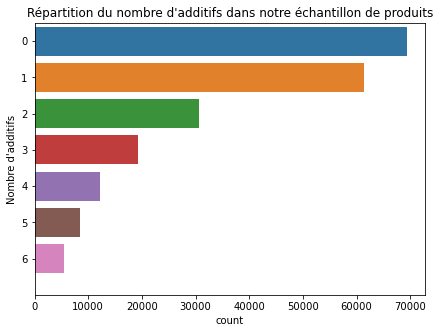

In [7]:
plt.figure(figsize=(7,5))
sns.countplot(y="additives_n", data=data)
plt.ylim(7)
plt.ylabel("Nombre d'additifs")
plt.title("Répartition du nombre d'additifs dans notre échantillon de produits")
plt.show()

Conformément à la gestion de nos valeurs aberrantes, nous avons une majorité de produits sans additifs mais plusieurs produits qui ont des additifs ne dépassent pas la valeur 6. Faisons l'analyse avec l'huile de palme :

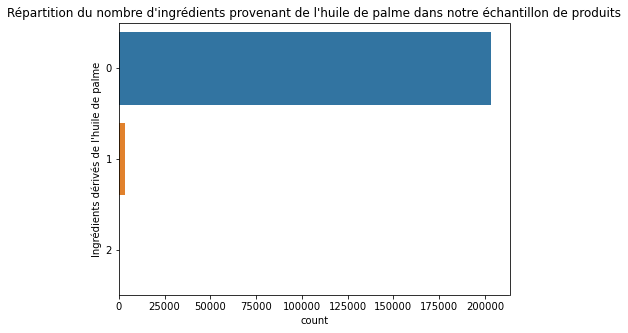

In [8]:
plt.figure(figsize=(7,5))
sns.countplot(y="ingredients_from_palm_oil_n", data=data)
plt.ylabel("Ingrédients dérivés de l'huile de palme")
plt.title("Répartition du nombre d'ingrédients provenant de l'huile de palme dans notre échantillon de produits")
plt.show()

Le fait que certains produits contiennent des additifs et de l'huile de palme nous conduit à prendre en compte ces éléments dans notre analyse. Le calcul de notre score final peut en être dépendant.
Analysons maintenant les catégories :

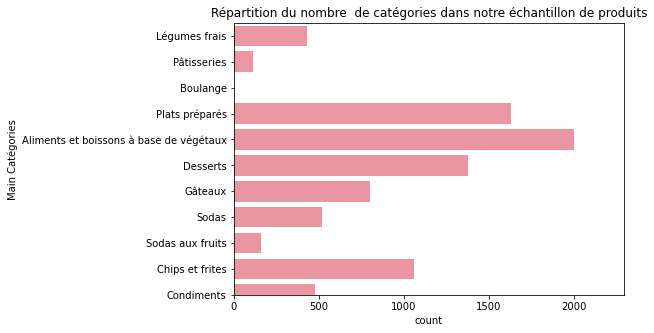

In [9]:
plt.figure(figsize=(7,5))
sns.countplot(y="main_category_fr", data=data)
plt.ylim(10)
plt.ylabel("Main Catégories")
plt.title("Répartition du nombre  de catégories dans notre échantillon de produits")
plt.show()

On a aussi des groupes "pnns" pour savoir quelles catégories sont les plus représentées

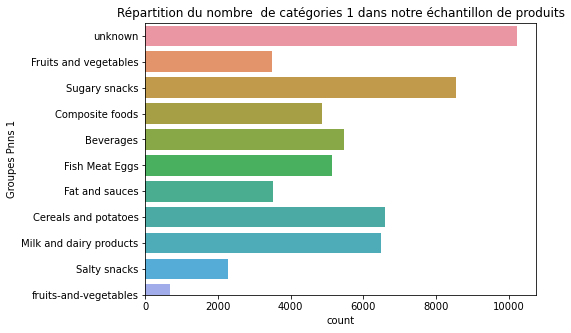

In [10]:
plt.figure(figsize=(7,5))
sns.countplot(y="pnns_groups_1", data=data)
plt.ylim(10)
plt.ylabel("Groupes Pnns 1")
plt.title("Répartition du nombre  de catégories 1 dans notre échantillon de produits")
plt.show()

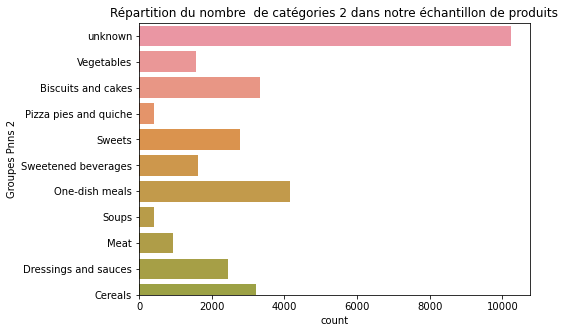

In [11]:
plt.figure(figsize=(7,5))
sns.countplot(y="pnns_groups_2", data=data)
plt.ylim(10)
plt.ylabel("Groupes Pnns 2")
plt.title("Répartition du nombre  de catégories 2 dans notre échantillon de produits")
plt.show()

On a une majorité de "unkown" qui biaise un peu nos données. Ceci dit, toutes les catégories sont bien représentées et nous allons voir par la suite si la catégorie a une influence sur le score nutritif.
Continuons notre analyse univariée par une représentation graphique de la répartition des grades dans notre échantillon (hors NaN) : 

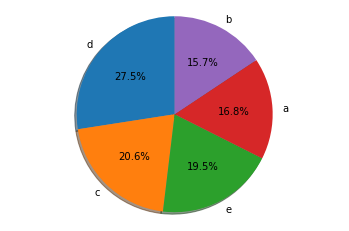

In [11]:
proportion_grade = data["nutrition_grade_fr"].value_counts() 
labels = proportion_grade.index
fig, ax = plt.subplots()
ax.pie(proportion_grade, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
plt.show()

# Analyses bivariées et multivariées

Dans un premier temps, on rappelle nos familles de colonnes qu'on a mis en place dans le notebook nettoyage, puis on trace la matrice de corrélation des données quantitatives et du nutriscore :

In [12]:
general = ['code', 'url', 'product_name', 'creator']
tags = ['brands','categories_fr','countries_fr']
misc = ['ingredients_text','serving_size','additives_fr','states_fr','main_category_fr']
energy = ['energy_100g']
nutrition_score = ['nutrition-score-fr_100g']
grade = ['nutrition_grade_fr']
additives = ['additives_n']
palme = ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
Nutri_100g = data.columns[(data.columns.str.contains('_100g'))& ~(data.columns.str.contains('energy'))& ~(data.columns.str.contains('score'))]

On trace la matrice de corrélation entre les différentes variables quantitatives :

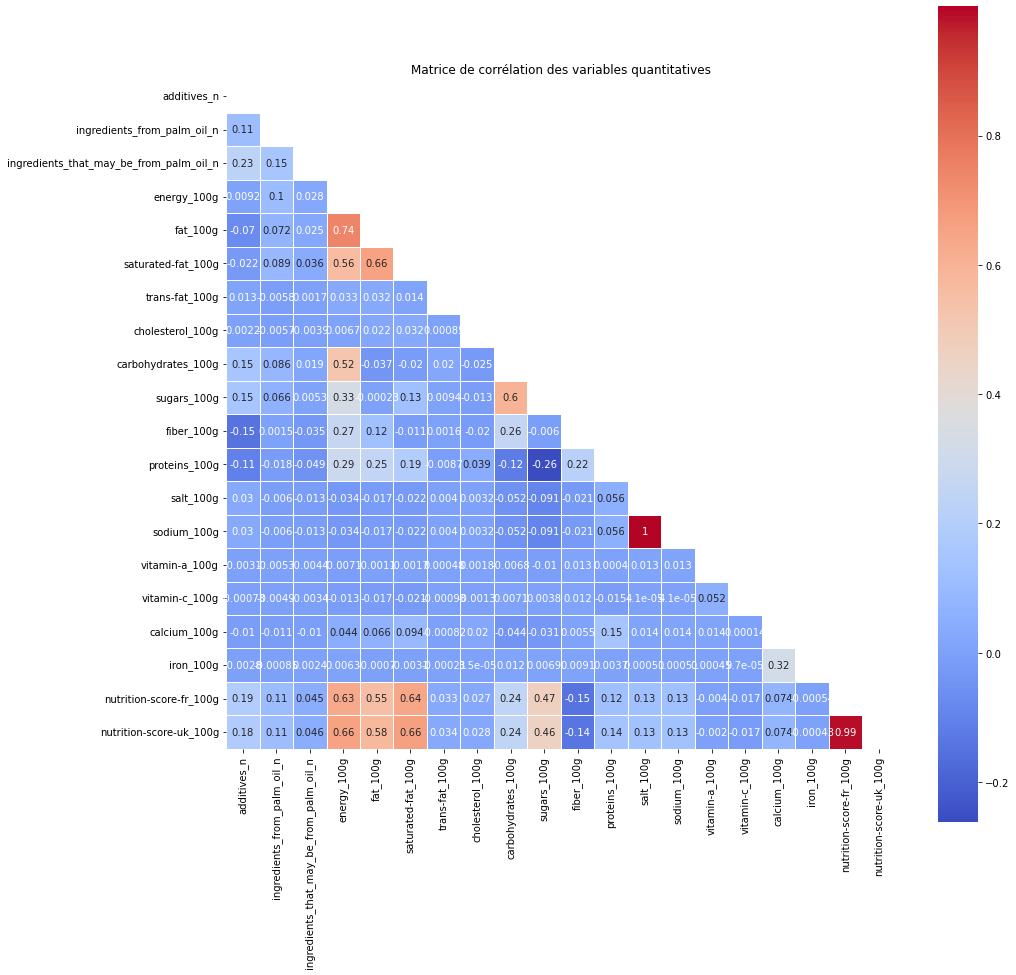

In [13]:
corr_matrix = data.corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="coolwarm", mask=mask, linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
plt.show()

La matrice de corrélation permet de voir les corrélations qui existent entre les différentes variables quantitatives. Une forte corrélation est constatée entre le score nutrition fr et anglais, on peut garder pour la suite uniquement le score français. Le sodium et le sel sont également corrélés à 1. On peut supprimer les variables sodium et nutriscore_uk.
On remarque une forte corrélation positive entre la quantité d'énergie en kcal pour 100g et la quantité de graisses pour 100g (0.72), la quantité de graisses saturées pour 100g (0.56) et la quantité de carbohydrates pour 100g (0.5). De plus, on remarque une forte corrélation positive entre la quantité de graisses pour 100g et la quantité de graisses saturées pour 100g (0.66). Enfin, on observe une dernière corrélation positive moyenne entre la quantité de sucres pour 100g et la quantité de carbohydrates pour 100g (0.65).
En revanche, le score nutritif semble ne pas se baser sur la présence d'additifs, d'huile de palme, de cholesterol, de carbnohydrates, de présence de sel, de sucre ou de vitamines.


In [14]:
suppr_100g = ['sodium_100g', 'nutrition-score-uk_100g']
data.drop(suppr_100g, axis=1, inplace=True)

# Analyses bivariées 

On entame notre analyse bivariée, sur la base de notre matrice de corrélation, pour confirmer ou infirmer nos hypothèses :

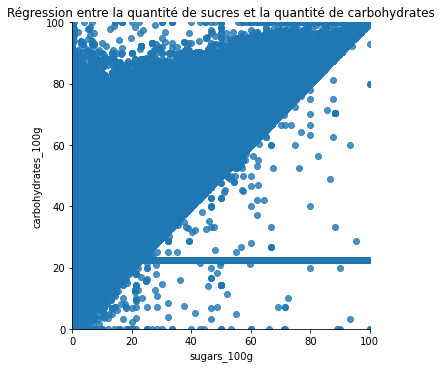

In [15]:
#sucre et hydrocarbonates :
sns.lmplot(x="sugars_100g", y="carbohydrates_100g", data=data)
plt.title("Régression entre la quantité de sucres et la quantité de carbohydrates")
plt.xlim(data["sugars_100g"].min(), data["sugars_100g"].max())
plt.ylim(data["carbohydrates_100g"].min(), data["carbohydrates_100g"].max())
plt.show()

Le sucre et le carbohydrate sont donc bien corrélés. Pour la suite de notre raisonnement, nous prendrons en compte uniquement le carbohydrate, puisque le sucre est beaucoup plus corrélé au nutriscore.

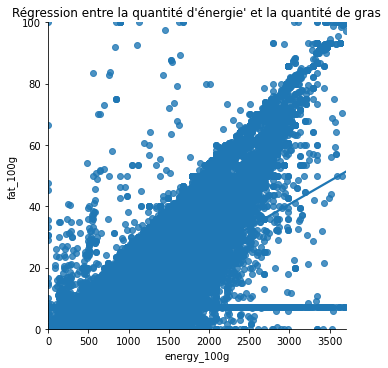

In [16]:
#Gras et énergie
sns.lmplot(x="energy_100g", y="fat_100g", data=data)
plt.title("Régression entre la quantité d'énergie' et la quantité de gras")
plt.xlim(data["energy_100g"].min(), data["energy_100g"].max())
plt.ylim(data["fat_100g"].min(), data["fat_100g"].max())
plt.show()

La corrélation est bien vérifiée entre nos deux variables. 

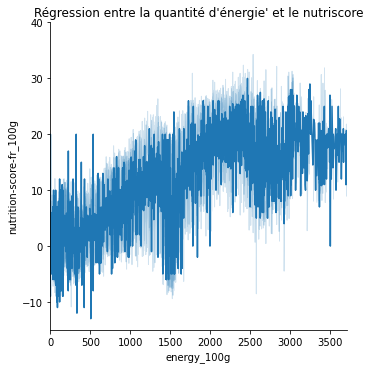

In [17]:
#Energie et nutriscore
sns.relplot(x="energy_100g", y="nutrition-score-fr_100g", kind="line", ci="sd", data=data)
plt.title("Régression entre la quantité d'énergie' et le nutriscore")
plt.xlim(data["energy_100g"].min(), data["energy_100g"].max())
plt.ylim(data["nutrition-score-fr_100g"].min(), data["nutrition-score-fr_100g"].max())
plt.show()

La corrélation est une nouvelle fois relativement respectée pour nos deux variables. A présent, nous allons tracer des graphiques de certaines variables en fonction de notre nutrition grade pour connaitre la tendance.

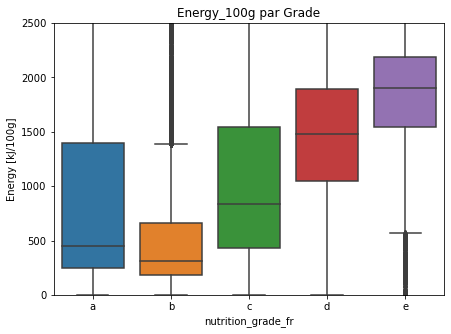

In [19]:
plt.figure(figsize = [7,5])
sns.boxplot(data = data, x = 'nutrition_grade_fr', y = 'energy_100g', order=['a','b','c','d','e'])
plt.ylim(0,2500)
plt.ylabel('Energy [kJ/100g]')
plt.title('Energy_100g par Grade');

In [20]:
data.groupby('nutrition_grade_fr').energy_100g.median()

nutrition_grade_fr
a     449.0
b     312.0
c     836.0
d    1477.0
e    1900.0
Name: energy_100g, dtype: float64

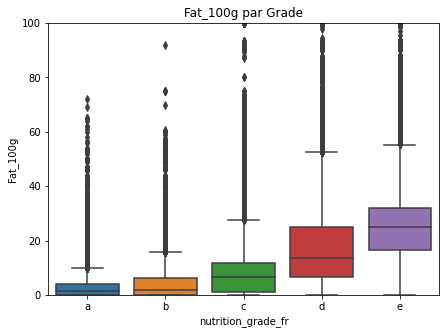

In [71]:
plt.figure(figsize = [7,5])
sns.boxplot(data = data, x = 'nutrition_grade_fr', y = 'fat_100g', order=['a','b','c','d','e'])
plt.ylim(0,100)
plt.ylabel('Fat_100g')
plt.title('Fat_100g par Grade');

In [22]:
data.groupby('nutrition_grade_fr').fat_100g.median()

nutrition_grade_fr
a     1.60
b     1.80
c     6.48
d    13.46
e    25.00
Name: fat_100g, dtype: float64

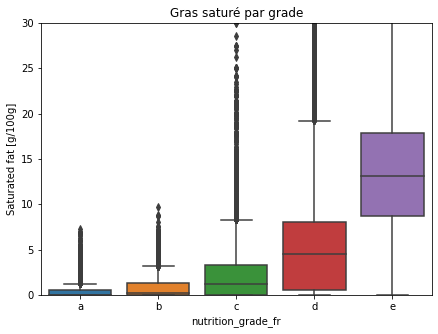

In [20]:
plt.figure(figsize = [7,5])
sns.boxplot(data = data, x = 'nutrition_grade_fr', y = 'saturated-fat_100g', order=['a','b','c','d','e'])
plt.ylim(0,30)
plt.ylabel('Saturated fat [g/100g]')
plt.title('Gras saturé par grade');

In [24]:
data.groupby('nutrition_grade_fr').fat_100g.median()

nutrition_grade_fr
a     1.60
b     1.80
c     6.48
d    13.46
e    25.00
Name: fat_100g, dtype: float64

On observe donc que plus le grade se rapproche de e (et donc moins sain), plus on a une augmentation du niveau d'énergie et de gras et de gras saturé.
Nous avons analysé les catégories dans notre analyse univariée, qu'en est-il en analyse bivariée au grade nutritionnel : 

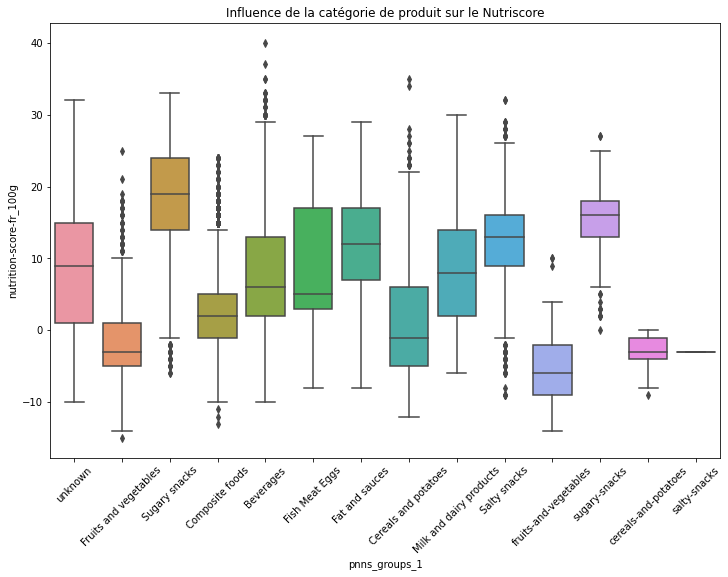

In [72]:
fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(data=data, x='pnns_groups_1', y='nutrition-score-fr_100g')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Influence de la catégorie de produit sur le Nutriscore")
plt.show()

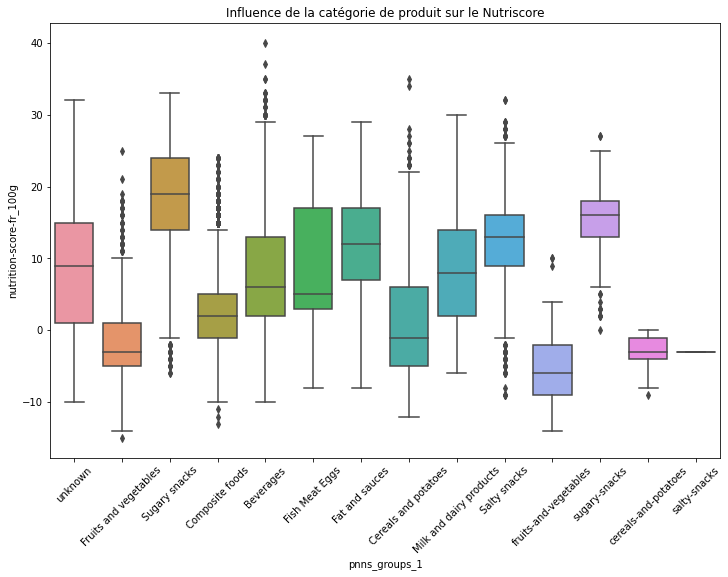

In [21]:
fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(data=data, x='pnns_groups_1', y='nutrition-score-fr_100g')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Influence de la catégorie de produit sur le Nutriscore")
plt.show()

Les graphiques ci-dessus nous montrent bien que la catégorie (qualitative) a une influence sur le nutriscore (quantitatif). Appliquons l'ANOVA pour le démontrer :

In [22]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

data["pnns"] = data["pnns_groups_1"]
data["nutrition"] = data["nutrition-score-fr_100g"]
model = ols("nutrition ~ C(pnns_groups_1)", data=data[["pnns_groups_1","nutrition"]], drop_cols=None ).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(pnns_groups_1),1.951324e+06,13.0,3001.467209,0.0
Residual,2.884098e+06,57671.0,NaN,NaN


Les résultats du test de Fisher nous indiquent ici une p-value de 0 pour l'ensemble des catégories, donc inferieur au niveau de test de 5%. La catégorie a donc bien une influence sur le nutriscore.

## Réduction des dimensions

In [23]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

In [26]:
data_pca = data[['nutrition-score-fr_100g', 'fat_100g', 'saturated-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g',
       'iron_100g']]

In [28]:
X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

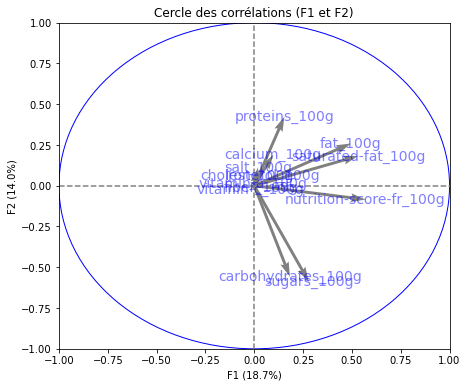

In [29]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

Grâce à cette réduction de dimensions, nous pouvons confirmer les hypothèses que nous avons évoquées sur la corrélation du nutriscore et de certaines valeurs (comme l'énergie) et prioriser deux catégories nutritives : Une catégorie « Good Nutrition » et une catégorie « Bad Nutrition ».
Suite à notre analyse bivariée, l'énergie, le gras et le gras saturé étant corrélés au nutriscore, nous les enleverons de notre analyse.
Le sucre étant corrélé au carbohydrates, nous choississons d'analyser la variable la moins corrélée au nutriscore, qui est le carbohydrate.
Créons nos nouvelles variables :


In [30]:
data_nutri_bad = ['cholesterol_100g','carbohydrates_100g','salt_100g']
data_nutri_good = ['fiber_100g', 'proteins_100g','vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']

Nous créons nos variables dépendant des variables du dataset

In [31]:
nutrition_score = 'nutrition-score-fr_100g'
grade ='nutrition_grade_fr'
additives = ['additives_n']
palme = ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']


In [32]:
data[data_nutri_good].describe()

,fiber_100g,proteins_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,206506.000000,206506.000000,206506.000000,206506.000000,206506.000000,206506.000000
mean,2.693485,7.877908,0.000087,0.004232,0.073500,0.002270
std,4.283441,8.191167,0.001850,0.097819,0.361049,0.138061
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.800000,0.000000,0.000000,0.016000,0.000620
50%,1.500000,5.730000,0.000000,0.000000,0.035000,0.001020
75%,3.500000,11.000000,0.000013,0.000000,0.060000,0.001290
max,100.000000,100.000000,0.800000,35.714300,82.000000,50.000000


# Création d'un score
Nous créons un score général se basant sur : Le nutriscore dans un premier temps, et un score entre 0 et 1 contenant les éléments non corrélés au nutriscore. 
Ce score calculé que nous créons sont basés sur la "good nutrition", la "bad nutrition", la présence d'additifs ou non, la présence d'huile de palme ou non.
En multipliant le nutriscore par notre score créé, nous obtenons un score beaucoup plus précis sur la qualité du produit, toujours compris entre -15 et 40. 

Nous allons maintenant créer un score entre 0 et 1 pour noter le critère "good nutrition" et "bad nutrition" de chaque produit

In [33]:
data['score_fiber'] = data['fiber_100g']/data['fiber_100g'].max()
data['score_proteins'] = data['proteins_100g']/data['proteins_100g'].max()
data['score_calcium'] = data['calcium_100g']/data['calcium_100g'].max()
data['score_vita'] = data['vitamin-a_100g']/data['vitamin-a_100g'].max()
data['score_vitc'] = data['vitamin-c_100g']/data['vitamin-c_100g'].max()
data['score_iron'] = data['iron_100g']/data['iron_100g'].max()

In [34]:
data['score_good_nutrition'] = data[['score_fiber','score_proteins','score_calcium','score_vita', 'score_vitc','score_iron']].mean(axis=1)

In [35]:
data['score_good_nutrition']

0         0.012054
1         0.041749
2         0.041908
3         0.039240
4         0.039232
            ...   
206501    0.009804
206502    0.031584
206503    0.055775
206504    0.001241
206505    0.000000
Name: score_good_nutrition, Length: 206506, dtype: float64

In [36]:
data[data_nutri_bad].describe()

,cholesterol_100g,carbohydrates_100g,salt_100g
count,206506.000000,206506.000000,206506.000000
mean,0.011960,31.724676,1.244482
std,0.265356,27.162303,4.025896
min,0.000000,0.000000,0.000000
25%,0.000000,7.350000,0.100000
50%,0.000000,22.470000,0.635000
75%,0.000000,56.300000,1.361440
max,95.238000,100.000000,100.000000


In [37]:
data['score_cholesterol'] = data['cholesterol_100g']/data['cholesterol_100g'].max()
data['score_carbohydrates'] = data['carbohydrates_100g']/data['carbohydrates_100g'].max()
data['score_salt'] = data['salt_100g']/data['salt_100g'].max()

In [38]:
data['score_bad_nutrition'] = (data['score_cholesterol'] + data['score_salt'] + data['score_carbohydrates'])/3

In [39]:
data['score_bad_nutrition']

0         0.214363
1         0.204483
2         0.063614
3         0.193166
4         0.127593
            ...   
206501    0.290302
206502    0.251600
206503    0.075233
206504    0.001751
206505    0.000000
Name: score_bad_nutrition, Length: 206506, dtype: float64

On passe au score de l'huile de palme

In [40]:
data['ingredients_from_palm_oil_n'].describe()

count    206506.000000
mean          0.016014
std           0.126452
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: ingredients_from_palm_oil_n, dtype: float64

In [41]:
data['score_palm'] = data['ingredients_from_palm_oil_n']/data['ingredients_from_palm_oil_n'].max()

In [42]:
data['score_palm']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
206501    0.0
206502    0.0
206503    0.0
206504    0.0
206505    0.0
Name: score_palm, Length: 206506, dtype: float64

On passe maintenant au score des additifs

In [43]:
data['score_additives'] = data['additives_n']/data['additives_n'].max()

In [44]:
data['score_additives']

0         0.000000
1         0.000000
2         0.000000
3         0.333333
4         0.166667
            ...   
206501    0.000000
206502    0.166667
206503    0.166667
206504    0.000000
206505    0.000000
Name: score_additives, Length: 206506, dtype: float64

On voit s'il y a corrélation entre toutes nos nouvelles variables

In [45]:
data[['score_bad_nutrition', 'score_good_nutrition', 'score_palm', 'score_additives', 'nutrition-score-fr_100g']].corr()

,score_bad_nutrition,score_good_nutrition,score_palm,score_additives,nutrition-score-fr_100g
score_bad_nutrition,1.000000,0.016241,0.084304,0.151582,0.260495
score_good_nutrition,0.016241,1.000000,-0.014457,-0.149317,0.036599
score_palm,0.084304,-0.014457,1.000000,0.108520,0.106203
score_additives,0.151582,-0.149317,0.108520,1.000000,0.187190
nutrition-score-fr_100g,0.260495,0.036599,0.106203,0.187190,1.000000


Nos scores ne sont clairement pas corrélés au nutriscore, comme nous le montre le tableau ci-dessus. 

In [98]:
#data['score_int'] = (data['score_good_nutrition'] - data[['score_bad_nutrition', 'score_additives','score_palm']].mean(axis=1)) 

On souhaite identifier les produits healthy, sand additifs, sans huile de palme, sans carbohydrates etc, et ne dépendant pas du nutriscore, voici la liste des critères que l'on recherche : Bon score "good nutrition", Score "bad nutrition" faible, Score additifs et palme faibles.
On crée la variable "score inter" qui sera notre coefficient. 

In [51]:
data['score_inter'] = (data['score_good_nutrition'] + 1-(data['score_bad_nutrition']) + 1-(data['score_additives']) + 1-(data['score_palm']))

In [52]:
data['score_inter'].describe()

count    206506.000000
mean          2.654922
std           0.307172
min           0.786098
25%           2.479895
50%           2.758508
75%           2.865592
max           3.174414
Name: score_inter, dtype: float64

Pour que notre coefficient puisse s'appliquer sans perturber le calcul du nutrigrade, nous pouvons diviser notre score intermédiaire par le score intermédiaire maximal, et ainsi avoir un coefficient entre 0 et 1.

In [53]:
data['score_inter'] = data['score_inter']/data['score_inter'].max()

In [54]:
data['score_inter'].describe()

count    206506.000000
mean          0.836350
std           0.096765
min           0.247636
25%           0.781214
50%           0.868982
75%           0.902715
max           1.000000
Name: score_inter, dtype: float64

L'étape finale sera donc de multiplier le score intermédiaire (score_inter) par le nutriscore. Le score final sera donc une pondération du nutriscore par notre coefficient. 

In [55]:
data['score_final'] = data['score_inter']*data['nutrition-score-fr_100g']

Pour avoir un score interprétable, nous arrondissons à l'unité notre score final et créons la variable qui représentera la valeur ajoutée de notre application par rapport à l'existant : Score your food.

In [56]:
data['score_your_food'] = np.round(data['score_final'], decimals = 0)  

On rassemble les scores dans une colonne, puis d'utiliser un groupby pour classer les produits du plus healthy au moins healthy suivant nos indicateurs.

In [61]:
features_score = ['code', 'product_name', 'nutrition-score-fr_100g', 'score_your_food','nutrition_grade_fr']

In [58]:
data_score = data[features_score]

In [62]:
data_score.sort_values(by=['score_your_food'], ascending=True).head(20)

,code,product_name,nutrition-score-fr_100g,score_your_food,nutrition_grade_fr
161710,3380390204408,Pois chiches,-15,-14.0,a
187589,5411788045094,Edamamé Beans Nature,-14,-13.0,a
155186,3270160103713,Fèves pelées,-14,-13.0,a
202413,8480000610232,Edamame,-14,-13.0,a
142112,3222471016886,Choux-fleurs en fleurettes,-14,-13.0,a
171151,3596710316045,Fèves pelées,-13,-12.0,a
172123,3596710402267,Petits pois extra fins,-13,-12.0,a
145373,3248451013164,Petits pois doux extra-fins,-13,-12.0,a
155178,3270160102068,Picard Bio Petit Pois Doux issus de l'Agricult...,-13,-12.0,a
168102,3564700005705,Petits pois doux extra fins,-13,-12.0,a


# Application concrète de "Score your food"

A priori, sur les premières lignes, on n'observe pas de changement. Mais, si on va plus loin dans l'analyse, nous verrons des différences :

In [63]:
data['nutrition-score-fr_100g'].describe()

count    206506.000000
mean          9.021999
std           9.120341
min         -15.000000
25%           1.000000
50%           9.000000
75%          16.000000
max          40.000000
Name: nutrition-score-fr_100g, dtype: float64

In [64]:
data['score_your_food'].describe()

count    206506.000000
mean          7.319158
std           7.544188
min         -14.000000
25%           1.000000
50%           7.000000
75%          13.000000
max          34.000000
Name: score_your_food, dtype: float64

Notre score final est plus précis que le nutriscore, puisque pondéré par un coefficient. L'échelle du calcul du nutrigrade restererait donc la même, le calcul serait plus affiné avec notre méthode.

In [66]:
data[data['nutrition_grade_fr']=='a'].score_your_food.max()

15.0

In [67]:
data_score[(data['nutrition_grade_fr']=='a') & (data.score_your_food>5)]

,code,product_name,nutrition-score-fr_100g,score_your_food,nutrition_grade_fr
137590,3057640406423,Volvic Limette,16,13.0,a
137840,3068320055008,Evian,10,9.0,a
198552,8002270020025,Sanpellegrino Sanbitter Dry,17,15.0,a
199667,8024884501400,Courmayeur,6,6.0,a
205995,9300624407652,Orange & Mango With Natural Mineral Water,10,9.0,a


On voit bien qu'il y a une erreur dans le grade piur ces 5 produits, qui sont censés être des produits ayant un grade bien plus bas. (c ou d)

In [68]:
data[(data['nutrition_grade_fr']=='e') & (data.score_final<-5)]

,code,url,creator,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,...,score_good_nutrition,score_cholesterol,score_carbohydrates,score_salt,score_bad_nutrition,score_palm,score_additives,score_inter,score_final,score_your_food


In [69]:
data_score[(data['nutrition_grade_fr']=='a') & (data.score_final>0)]

,code,product_name,nutrition-score-fr_100g,score_your_food,nutrition_grade_fr
132146,20656935,Pétillante saveur Citron,1,1.0,a
137590,3057640406423,Volvic Limette,16,13.0,a
137839,3068320019628,Sans sucres Agrumes,1,1.0,a
137840,3068320055008,Evian,10,9.0,a
137841,3068320102993,La Salvetat Citron vert,1,1.0,a
137842,3068320105192,Badoit Citron,1,1.0,a
137846,3068320107844,Badoit Framboise,1,1.0,a
137860,3068320693002,La Salvetat Citron,1,1.0,a
141332,3179732368942,"Perrier citron vert, limoen",1,1.0,a
156391,3271330062939,Sémillante arômes naturels Citron,4,3.0,a


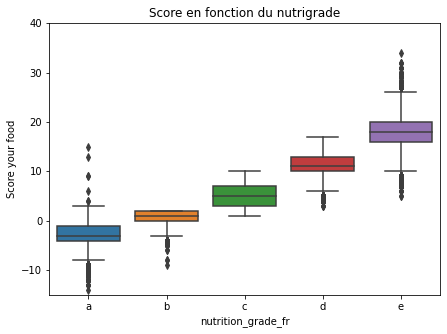

In [70]:
plt.figure(figsize = [7,5])
sns.boxplot(data = data, x = 'nutrition_grade_fr', y = 'score_your_food', order=['a','b','c','d','e'])
plt.ylim(-15,40)
plt.ylabel('Score your food')
plt.title('Score en fonction du nutrigrade');

# Allons plus loin en créant notre grade :

Notre grade "Grade your food" sera entièrement basé sur notre score. Rappelons que par rapport au nutriscore, "Score your food" englobe plusieurs données supplémentaires, comme les additifs, l'huile de palme, la présence de sel, de carbohydrates, d'additifs, de vitamines, de fer, de protéines...
Nous faisons le choix d'attribuer 4 grades : 

In [90]:

# On crée nos conditions
conditions = [
    (data['score_your_food'] <= 0),
    (data['score_your_food'] >= 1) & (data['score_your_food'] <= 5),
    (data['score_your_food'] >= 6) & (data['score_your_food']<= 9),
     data['score_your_food'] >= 10
    ]

In [91]:
# On crée une liste de valeurs à attribuer à chaque condition
values = ['Excellent', 'Good', 'Fair', 'Poor']

In [92]:
# On crée une nouvelle colonne et on utilise np.select pour attribuer les grades en fonction de nos conditions
data['Grade_your_food'] = np.select(conditions, values)

In [94]:
#On actualise notre tableau de données :
features = ['code', 'product_name', 'nutrition-score-fr_100g','nutrition_grade_fr', 'score_your_food', 'Grade_your_food']
data_features = data[features]

In [95]:
# Voici le dataframe :
data_features.head()

,code,product_name,nutrition-score-fr_100g,nutrition_grade_fr,score_your_food,Grade_your_food
0,4530,Banana Chips Sweetened (Whole),14,d,12.0,Poor
1,4559,Peanuts,0,b,0.0,Excellent
2,16087,Organic Salted Nut Mix,12,d,11.0,Poor
3,16124,Organic Muesli,7,c,6.0,Fair
4,16872,Zen Party Mix,12,d,10.0,Poor


La valeur ajoutée de notre application sera également de challenger les grades existants. Dans notre cas, un nutrigrade "e" est censé contenir uniquement le grade "Poor". 

In [96]:
data_features[(data['nutrition_grade_fr']=='e') & (data['Grade_your_food']!='Poor')]

,code,product_name,nutrition-score-fr_100g,nutrition_grade_fr,score_your_food,Grade_your_food
7211,12000041396,Iced Coffee,10,e,9.0,Fair
7858,14100097006,Chocolate Chunk Milk Chocolate Macadamia Crisp...,21,e,9.0,Fair
7859,14100097013,Chocolate Chunk White Chocolate Macadamia Cris...,20,e,8.0,Fair
42866,469258,Chocolate Chip Cookies,21,e,9.0,Fair
72308,79800121086,Pass-o-Guava,10,e,7.0,Fair
...,...,...,...,...,...,...
205725,9002515426420,Pago goyave,10,e,9.0,Fair
205823,90162602,Red Bull,15,e,9.0,Fair
205844,90382277,Iced tea pêssego,11,e,9.0,Fair
205900,9120008992433,"Höllinger Cranberry Sprizz, 0,5 LTR Flasche",10,e,8.0,Fair


In [97]:
data_features[(data['nutrition_grade_fr']=='e') & (data['Grade_your_food']=='Poor')]

,code,product_name,nutrition-score-fr_100g,nutrition_grade_fr,score_your_food,Grade_your_food
17,18500,Dark Chocolate Coconut Chews,19,e,16.0,Poor
22,18883,Dark Chocolate Sea Salt & Turbinado Almonds,26,e,22.0,Poor
39,36252,Lion Peanut x2,22,e,18.0,Poor
40,36269,Milk Chocolate Peanut Butter Malt Balls,23,e,18.0,Poor
42,36986,Yogurt Pretzels,30,e,23.0,Poor
...,...,...,...,...,...,...
206460,9556041612661,Sauce Pour Nems,20,e,14.0,Poor
206466,9556156036765,Sauce,19,e,16.0,Poor
206468,9556156040182,Lychee Drink,13,e,10.0,Poor
206471,9556156046641,Yeo's Soy Bean Drink,14,e,12.0,Poor


On effectue une analyse graphique bivariée pour comprendre la réparition de notre score et notre grade :

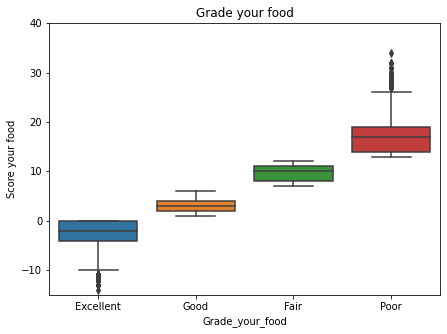

In [87]:
plt.figure(figsize = [7,5])
sns.boxplot(data = data, x = 'Grade_your_food', y = 'score_your_food', order=['Excellent', 'Good', 'Fair', 'Poor'])
plt.ylim(-15,40)
plt.ylabel('Score your food')
plt.title('Grade your food');

In [100]:
data_features[(data['nutrition_grade_fr']=='b') & (data['Grade_your_food']=='Poor')]

,code,product_name,nutrition-score-fr_100g,nutrition_grade_fr,score_your_food,Grade_your_food


Exemple du grade "Poor" qui n'est pas mis en nutrigrade "e".

In [103]:
data_features[(data['nutrition_grade_fr']!='e') & (data['Grade_your_food']=='Poor')]

,code,product_name,nutrition-score-fr_100g,nutrition_grade_fr,score_your_food,Grade_your_food
0,4530,Banana Chips Sweetened (Whole),14,d,12.0,Poor
2,16087,Organic Salted Nut Mix,12,d,11.0,Poor
4,16872,Zen Party Mix,12,d,10.0,Poor
8,18265,Energy Power Mix,14,d,13.0,Poor
9,18289,Antioxidant Mix - Berries & Chocolate,15,d,13.0,Poor
...,...,...,...,...,...,...
206491,96087763,Coffee & Chocolate With Peanuts 12 x 45G,11,d,10.0,Poor
206492,96087770,Peanut & Popcorn With Dark Chocolate 12 x 45G,15,d,13.0,Poor
206493,96092514,Blue Cheese Dressing,17,d,15.0,Poor
206495,96103890,Eat Natural Protein Packed,17,d,15.0,Poor


L'analyse peut se faire sur tous les produits et peut être déterminante pour challenger le nutriscore, ou créer un grade plus complet.